# Comprehensive Audiology Research Analysis Pipeline
**Subject Analysis: CRM, Vowel, and Consonant Perception**

## 1. Setup and Configuration
This section imports necessary libraries and sets visualization standards for publication-quality plots.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
import os
import re
import glob
import warnings

# --- PLOTTING AESTHETICS ---
sns.set_theme(style="whitegrid", context="paper", font_scale=1.2)
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['figure.figsize'] = [12, 6]
warnings.filterwarnings('ignore')

# --- STATISTICAL HELPER ---
def report_stats(group1, group2, label1, label2, metric_name):
    """
    Automatically selects between T-test (parametric) and Mann-Whitney U (non-parametric)
    based on Shapiro-Wilk normality test.
    """
    # 1. Test Normality
    _, p1 = stats.shapiro(group1)
    _, p2 = stats.shapiro(group2)
    
    print(f"\n--- Statistical Comparison: {label1} vs {label2} ({metric_name}) ---")
    print(f"Normality Check (p>0.05 is normal): {label1} p={p1:.3f}, {label2} p={p2:.3f}")
    
    if p1 > 0.05 and p2 > 0.05:
        # Variances equal?
        _, p_levene = stats.levene(group1, group2)
        if p_levene > 0.05:
            stat, p = stats.ttest_ind(group1, group2)
            test_used = "Student's T-test (Equal Variance)"
        else:
            stat, p = stats.ttest_ind(group1, group2, equal_var=False)
            test_used = "Welch's T-test (Unequal Variance)"
    else:
        stat, p = stats.mannwhitneyu(group1, group2)
        test_used = "Mann-Whitney U (Non-parametric)"
        
    # Effect Size (Cohen's d for parametric)
    n1, n2 = len(group1), len(group2)
    s1, s2 = np.std(group1, ddof=1), np.std(group2, ddof=1)
    pooled_std = np.sqrt(((n1 - 1) * s1**2 + (n2 - 1) * s2**2) / (n1 + n2 - 2))
    cohens_d = (np.mean(group1) - np.mean(group2)) / pooled_std
    
    print(f"Test Selected: {test_used}")
    print(f"Statistic: {stat:.3f} | p-value: {p:.4f}")
    print(f"Means: {label1}={np.mean(group1):.2f}, {label2}={np.mean(group2):.2f}")
    print(f"Effect Size (Cohen's d): {cohens_d:.3f}")
    return p < 0.05

## 2. Data Management & Mapping
**CRITICAL:** Define the mapping of Run Numbers to Experimental Conditions below.

In [2]:
# --- 2.1 USER DEFINED MAPPING ---
# UPDATE THIS DICTIONARY BEFORE RUNNING
# Format: {Run_Number: 'Condition_Label'}
crm_run_mapping = {
    0: 'Practice',
    1: 'BM',
    2: 'BM',
    3: 'BM',
    4: 'CI',
    5: 'HA',
    6: 'CI',
    7: 'HA',
    8: 'BM',
    9: 'HA',
    10: 'CI'
}

print("Current Condition Mapping:")
print(crm_run_mapping)

Current Condition Mapping:
{0: 'Practice', 1: 'BM', 2: 'BM', 3: 'BM', 4: 'CI', 5: 'HA', 6: 'CI', 7: 'HA', 8: 'BM', 9: 'HA', 10: 'CI'}


In [3]:
# --- 2.2 Data Loading Logic ---

base_path = input("Enter the directory path containing your data files: ").strip()
if not os.path.isdir(base_path):
    raise FileNotFoundError(f"Directory not found: {base_path}")
    
subject_id = os.path.basename(base_path)
print(f"\nLoading data for Subject: {subject_id}...")

# -- Helpers --
def get_gender(talker_id):
    return 'M' if talker_id <= 3 else 'F'

def parse_crm_header(filepath):
    try:
        with open(filepath, 'r') as f:
            header = f.readline()
        match = re.search(r'Talker (\d+), Maskers (\d+) and (\d+)', header)
        if match:
            return int(match.group(1)), int(match.group(2)), int(match.group(3))
    except: pass
    return None, None, None

def calculate_srt(df_run):
    # Calculate SRT based on reversals 5-14
    snr = df_run['snr'].values
    correct = ((df_run['tc'] == df_run['rc']) & (df_run['tn'] == df_run['rn'])).values
    reversals = []
    prev = correct[0]
    for i in range(1, len(correct)):
        if correct[i] != prev:
            reversals.append(snr[i])
        prev = correct[i]
    
    if len(reversals) >= 5:
        calc_revs = reversals[4:14] if len(reversals) >= 14 else reversals[4:]
        return np.mean(calc_revs), np.std(calc_revs)
    return np.nan, np.nan

# -- Load CRM --
crm_files = sorted([f for f in os.listdir(base_path) if '_crm_' in f and f.endswith('.txt')])
crm_data = []
crm_summary = []

for f in crm_files:
    run_id = int(re.search(r'_crm_(\d+)', f).group(1))
    condition = crm_run_mapping.get(run_id, 'Unknown')
    
    fpath = os.path.join(base_path, f)
    talker, m1, m2 = parse_crm_header(fpath)
    
    if talker is not None:
        t_gen = get_gender(talker)
        m_gen = get_gender(m1)
        masker_type = "Same" if t_gen == m_gen else "Diff"
        
        try:
            # Load trial data
            df_temp = pd.read_csv(fpath, sep='\\s+', header=None, skiprows=2, 
                                  names=['run', 'tc', 'rc', 'tn', 'rn', 'snr', 'rt'], on_bad_lines='skip')
            df_temp = df_temp[pd.to_numeric(df_temp['run'], errors='coerce').notna()].astype(float)
            
            # Enrich data
            df_temp['condition'] = condition
            df_temp['masker_type'] = masker_type
            df_temp['talker_gender'] = t_gen
            df_temp['run_id'] = run_id
            df_temp['is_correct'] = (df_temp['tc'] == df_temp['rc']) & (df_temp['tn'] == df_temp['rn'])
            
            # Categorize Errors
            conditions = [
                (df_temp['tc'] == df_temp['rc']) & (df_temp['tn'] == df_temp['rn']),
                (df_temp['tc'] == df_temp['rc']) & (df_temp['tn'] != df_temp['rn']),
                (df_temp['tc'] != df_temp['rc']) & (df_temp['tn'] == df_temp['rn'])
            ]
            choices = ['Correct', 'Number Err', 'Color Err']
            df_temp['err_type'] = np.select(conditions, choices, default='Both Err')
            
            crm_data.append(df_temp)
            
            # Summary SRT
            srt, sd = calculate_srt(df_temp)
            crm_summary.append([run_id, condition, masker_type, t_gen, srt, sd])
            
        except Exception as e:
            print(f"Error processing {f}: {e}")

if crm_data:
    df_crm = pd.concat(crm_data).reset_index(drop=True)
    df_crm_summary = pd.DataFrame(crm_summary, columns=['run', 'condition', 'masker_type', 'gender', 'srt', 'sd'])
    print(f"CRM Data: Loaded {len(crm_summary)} runs.")
else:
    df_crm = pd.DataFrame()

# -- Load Vowels/Consonants (Assuming standard naming) --
vow_cols = ['talker', 'target', 'resp', 'score', 'rt']
try:
    df_vow = pd.read_csv(os.path.join(base_path, f'{subject_id}_vow9_BM_0.txt'), sep='\\s+', header=None, names=vow_cols)
    df_vow['condition'] = 'BM'
    df_vow_ci = pd.read_csv(os.path.join(base_path, f'{subject_id}_vow9_CI_0.txt'), sep='\\s+', header=None, names=vow_cols)
    df_vow_ci['condition'] = 'CI'
    df_vow = pd.concat([df_vow, df_vow_ci], ignore_index=True)
    
    # Mapping
    v_map = {1:'AE', 2:'AH', 3:'AW', 4:'EH', 5:'IH', 6:'IY', 7:'OO', 8:'UH', 9:'UW'}
    df_vow['target_lbl'] = df_vow['target'].map(v_map)
    df_vow['resp_lbl'] = df_vow['resp'].map(v_map)
    print(f"Vowel Data: Loaded {len(df_vow)} trials.")
except: 
    print("Vowel data missing or named incorrectly.")
    df_vow = pd.DataFrame()

try:
    c_cols = ['talker', 'target', 'resp', 'score', 'rt']
    df_cons = pd.read_csv(os.path.join(base_path, f'{subject_id}_cons_BM_n_0.out'), sep='\\s+', header=None, names=c_cols)
    c_map = {1:'#', 2:'_', 3:'b', 4:'d', 5:'f', 6:'g', 7:'k', 8:'m', 9:'n', 10:'%', 11:'p', 12:'s', 13:'t', 14:'v', 15:'z', 16:'$'}
    df_cons['target_lbl'] = df_cons['target'].map(c_map)
    df_cons['resp_lbl'] = df_cons['resp'].map(c_map)
    print(f"Consonant Data: Loaded {len(df_cons)} trials.")
except:
    print("Consonant data missing.")
    df_cons = pd.DataFrame()
    

# /Users/samipkafle/Downloads/reiss_lab_analysis/data/Data/CI148

Enter the directory path containing your data files:  /Users/samipkafle/Downloads/reiss_lab_analysis/data/Data/CI148



Loading data for Subject: CI148...
CRM Data: Loaded 11 runs.
Vowel Data: Loaded 360 trials.
Consonant Data: Loaded 64 trials.


## 3. Phonetic Feature Analysis (Consonants)
**Methodology:**
We utilize the Miller-Nicely (1955) approach to decompose phoneme errors into three distinct features:
1.  **Voicing:** Vibration of vocal cords (e.g., /b/ vs /p/). Errors here suggest low-frequency hearing issues.
2.  **Place:** Where the sound is made (Lips vs Throat). High frequency dependent.
3.  **Manner:** How the sound is made (Stop vs Fricative).

The analysis calculates the **Information Transfer Rate** (% Correct) for each specific feature, independent of the whole letter.

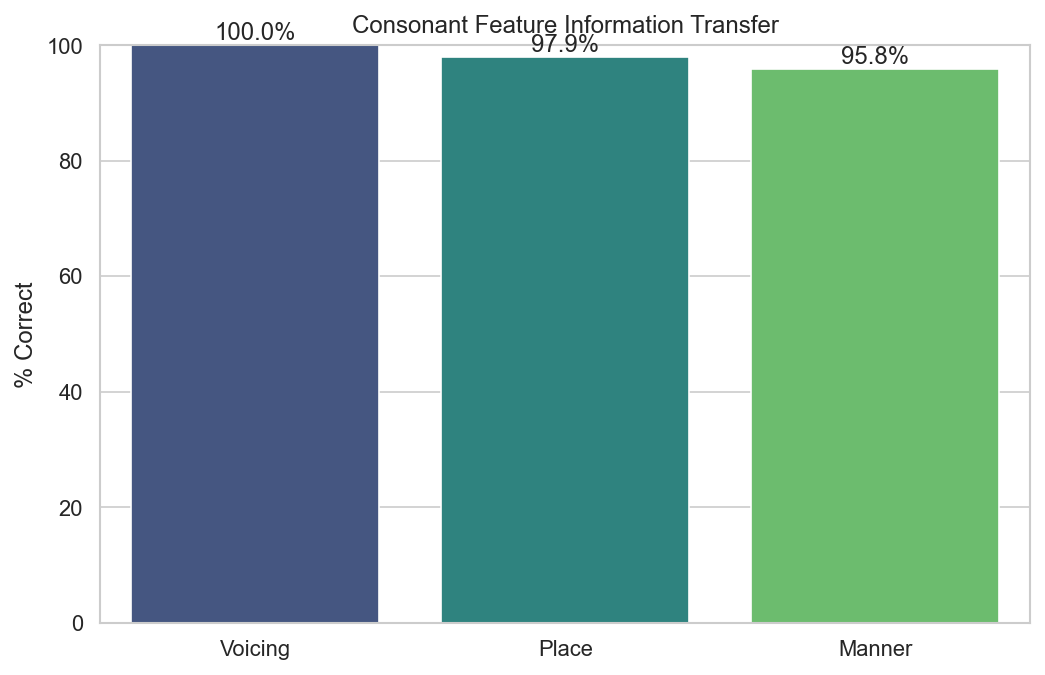

In [4]:
if not df_cons.empty:
    # Feature Map: (Voicing, Place, Manner)
    # 0=Low/Front/Stop, 1=High/Back/Cont
    # Simplified mapping for demonstration purposes
    feat_map = {
        'b':(1,0,0), 'd':(1,1,0), 'g':(1,2,0), 'p':(0,0,0), 't':(0,1,0), 'k':(0,2,0),
        'm':(1,0,1), 'n':(1,1,1), 'f':(0,0,2), 'v':(1,0,2), 's':(0,1,2), 'z':(1,1,2)
        # Note: #, _, %, $ excluded in this simple map for robust calculation
    }
    
    valid_df = df_cons[df_cons['target_lbl'].isin(feat_map.keys()) & df_cons['resp_lbl'].isin(feat_map.keys())].copy()
    
    features = ['Voicing', 'Place', 'Manner']
    res = {}
    
    for i, feat in enumerate(features):
        t = valid_df['target_lbl'].apply(lambda x: feat_map[x][i])
        r = valid_df['resp_lbl'].apply(lambda x: feat_map[x][i])
        res[feat] = (t == r).mean() * 100

    # Visualization
    plt.figure(figsize=(8, 5))
    ax = sns.barplot(x=list(res.keys()), y=list(res.values()), palette='viridis')
    plt.ylim(0, 100)
    plt.title("Consonant Feature Information Transfer")
    plt.ylabel("% Correct")
    for i, v in enumerate(res.values()):
        ax.text(i, v+1, f"{v:.1f}%", ha='center')
    plt.show()

## 4. Confusion Matrices
**Methodology:**
These matrices show exactly which stimuli were confused. 
- **Diagonal:** Correct identifications.
- **Off-Diagonal:** Errors. Specific clusters off-diagonal indicate systematic perceptual biases (e.g., hearing 'b' as 'p').

**Dual View:** Left plot shows absolute counts. Right plot shows row-normalized probabilities (likelihood of response given target).

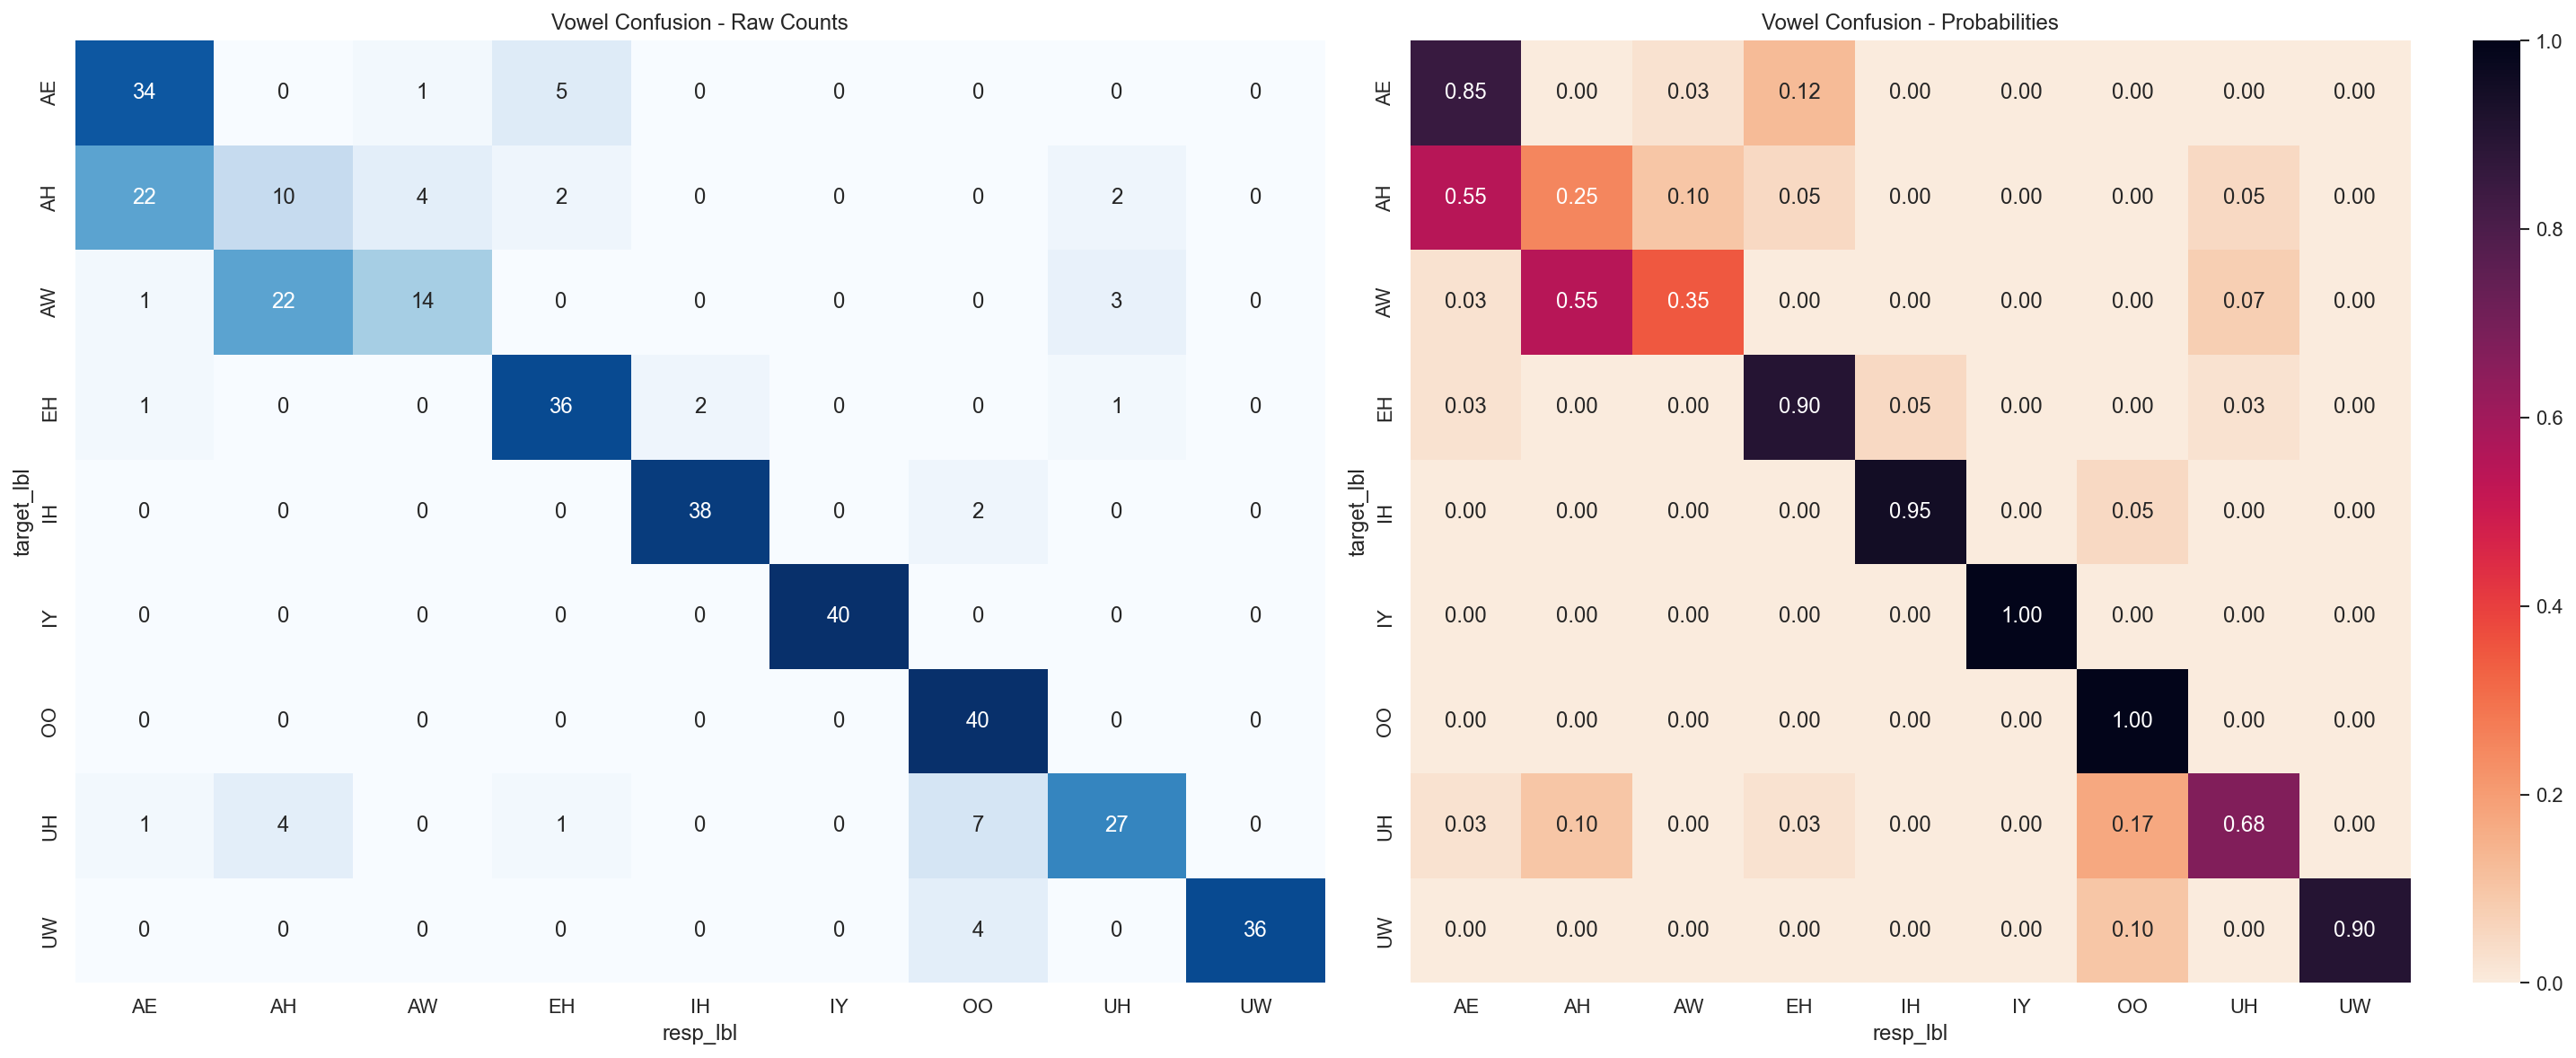

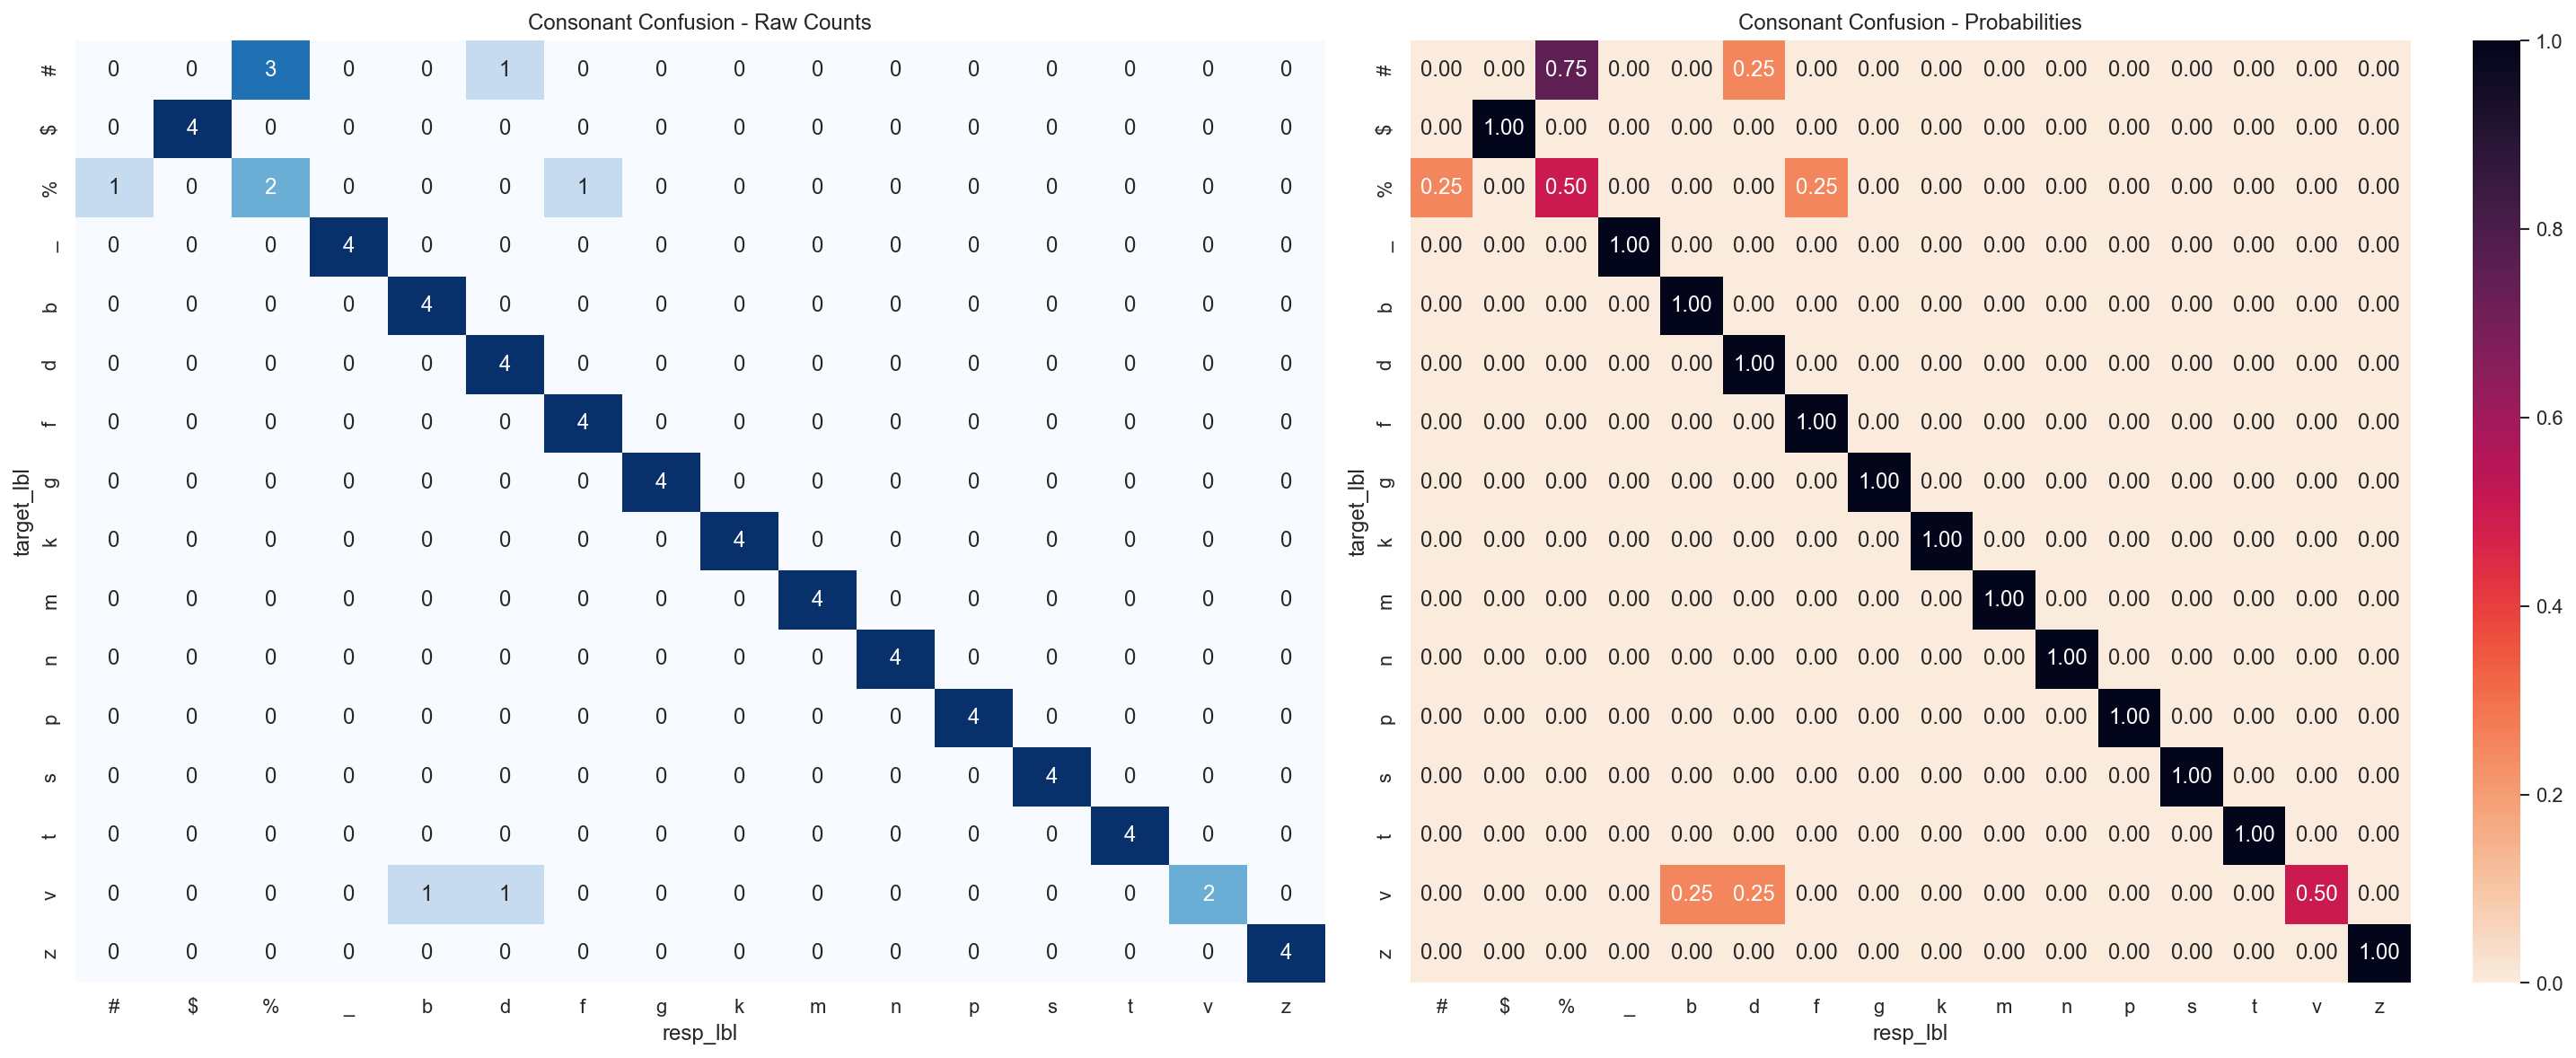

In [5]:
def plot_dual_matrix(df, target_col, resp_col, title):
    if df.empty: return
    
    labels = sorted(list(set(df[target_col].unique()) | set(df[resp_col].unique())))
    
    # Counts
    cm_counts = pd.crosstab(df[target_col], df[resp_col]).reindex(index=labels, columns=labels, fill_value=0)
    # Probs
    cm_prob = cm_counts.div(cm_counts.sum(axis=1), axis=0).fillna(0)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    sns.heatmap(cm_counts, annot=True, fmt='d', cmap='Blues', ax=ax1, cbar=False)
    ax1.set_title(f'{title} - Raw Counts')
    
    sns.heatmap(cm_prob, annot=True, fmt='.2f', cmap='rocket_r', ax=ax2)
    ax2.set_title(f'{title} - Probabilities')
    
    plt.tight_layout()
    plt.show()

# 4.1 Vowel Matrices
if not df_vow.empty:
    plot_dual_matrix(df_vow, 'target_lbl', 'resp_lbl', "Vowel Confusion")

# 4.2 Consonant Matrices
if not df_cons.empty:
    plot_dual_matrix(df_cons, 'target_lbl', 'resp_lbl', "Consonant Confusion")

## 5. CRM SRT Analysis (Granular Breakdown)
**Rationale:** Speech Reception Thresholds (SRT) are calculated using adaptive tracking. We stratify by Condition, Masker Type, and Gender to find interactions (e.g., does Bimodal aid in spatial release from masking?).

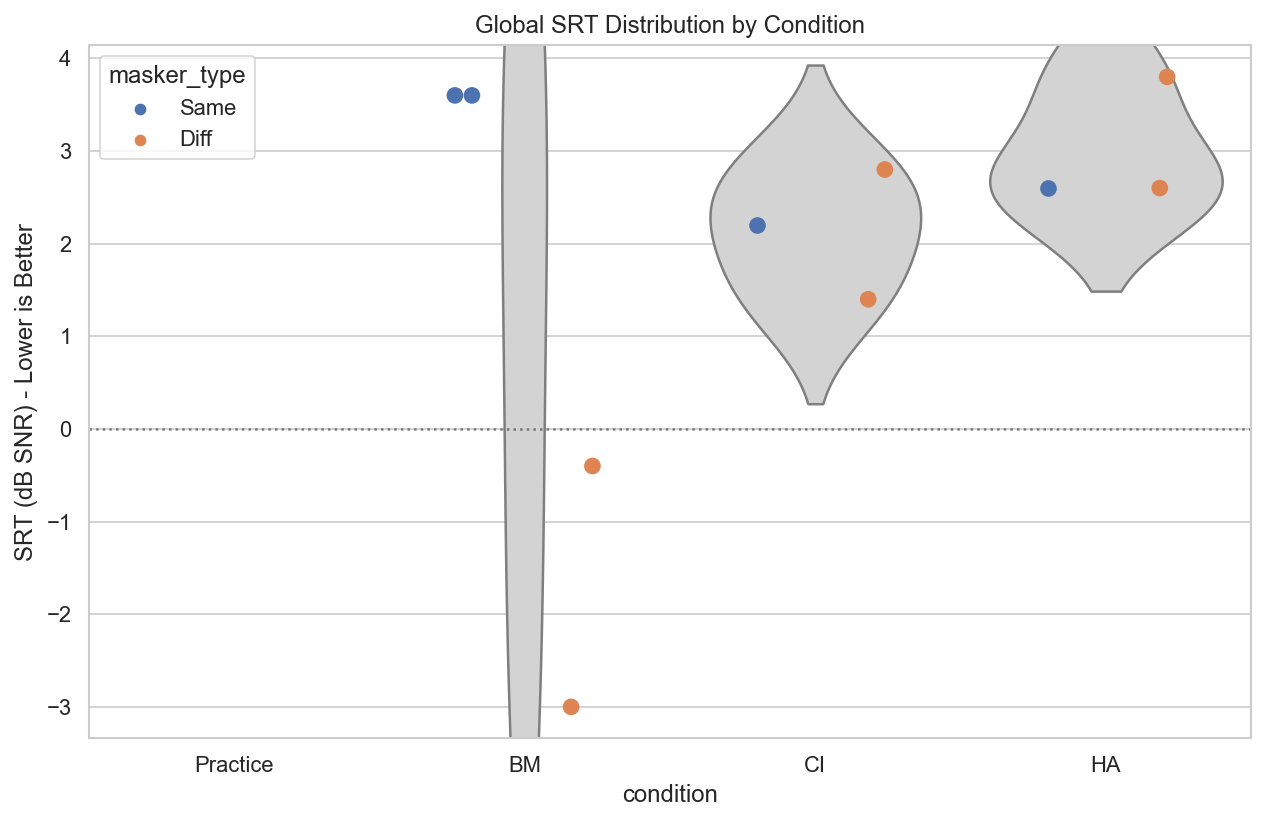

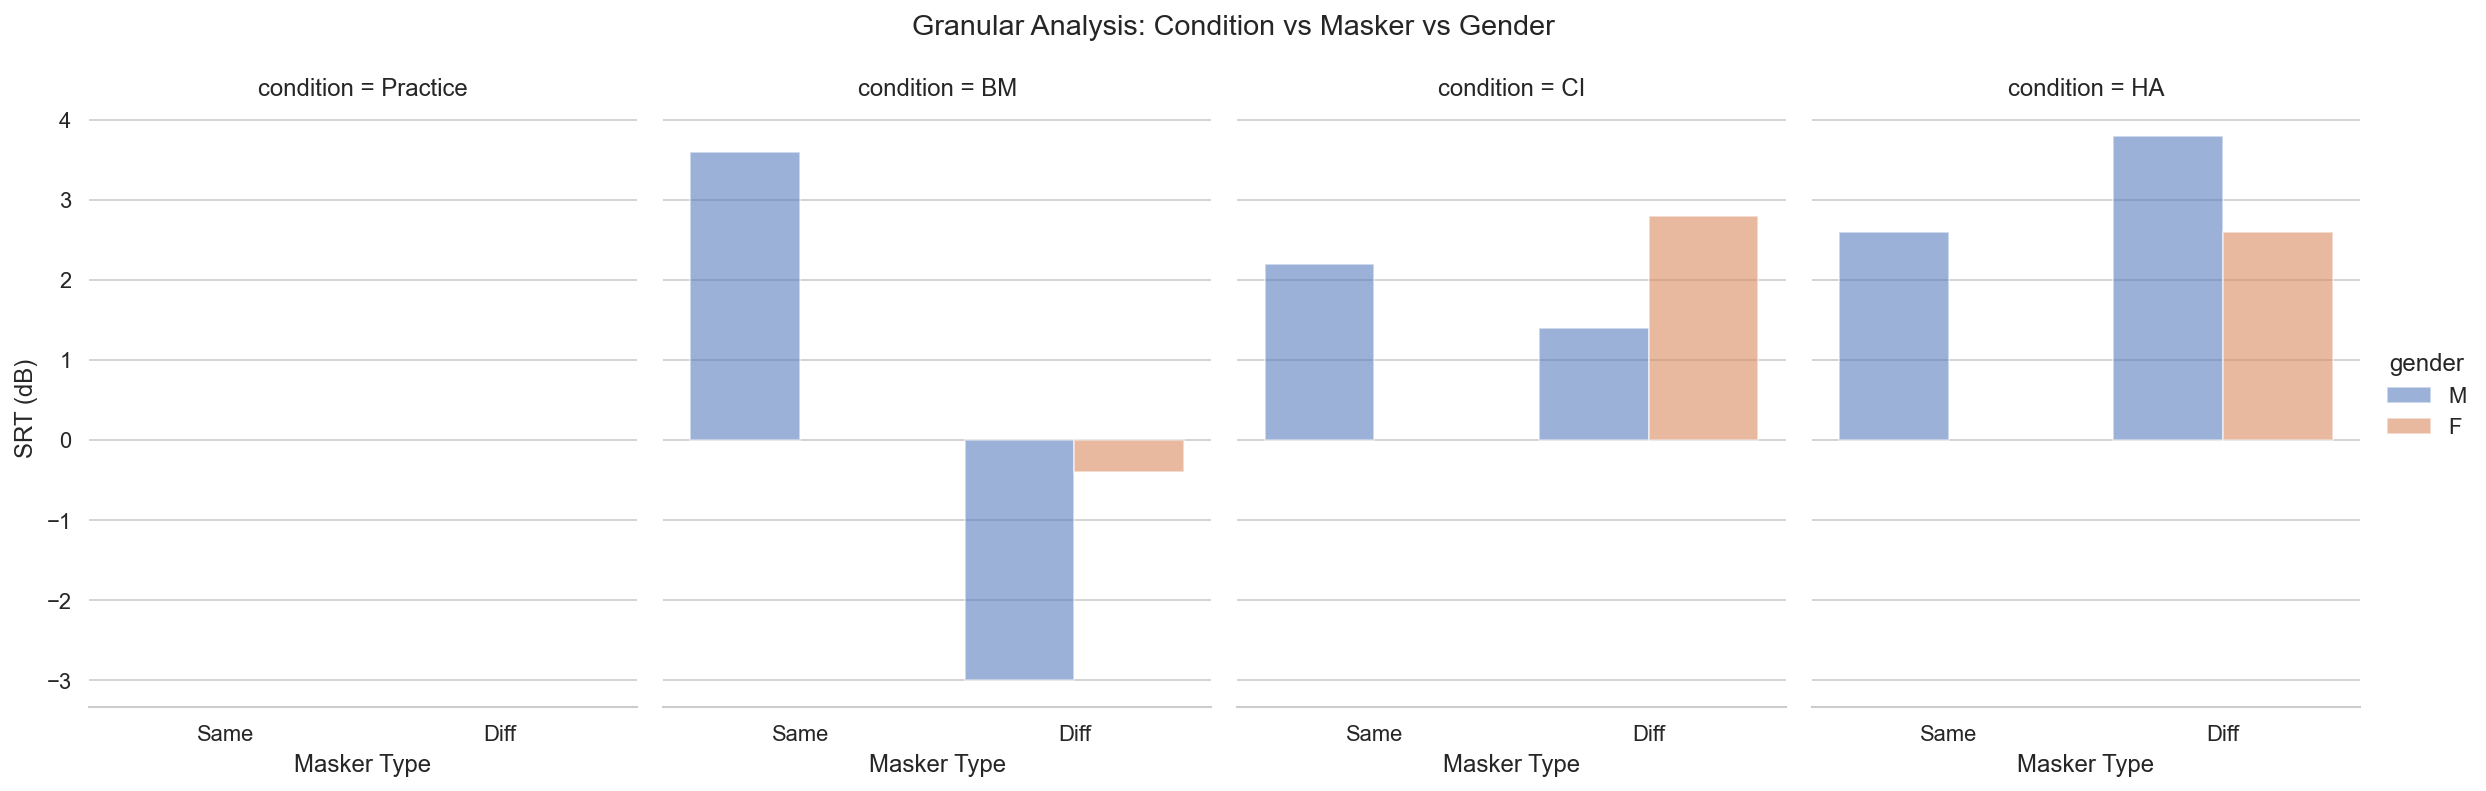


--- ANOVA Results: SRT ~ Condition + Masker ---
                   sum_sq   df         F    PR(>F)
C(condition)    15.292857  3.0  1.338850  0.330552
C(masker_type)  10.571905  1.0  2.776629  0.146699
Residual        22.844762  6.0       NaN       NaN


In [6]:
if not df_crm_summary.empty:
    valid_crm = df_crm_summary[df_crm_summary['condition'] != 'Unknown'].copy()
    
    # 5.1 Global Violin Plot
    plt.figure(figsize=(10, 6))
    sns.violinplot(x='condition', y='srt', data=valid_crm, inner=None, color='lightgray')
    sns.stripplot(x='condition', y='srt', hue='masker_type', data=valid_crm, size=8, jitter=True, dodge=True)
    plt.title('Global SRT Distribution by Condition')
    plt.ylabel('SRT (dB SNR) - Lower is Better')
    plt.axhline(0, color='k', linestyle=':', alpha=0.5)
    plt.show()
    
    # 5.2 Granular Facet Grid (Condition x Masker x Gender)
    g = sns.catplot(
        data=valid_crm, kind="bar",
        x="masker_type", y="srt", hue="gender", col="condition",
        errorbar="sd", palette="muted", alpha=.6, height=5, aspect=0.8
    )
    g.despine(left=True)
    g.set_axis_labels("Masker Type", "SRT (dB)")
    g.fig.suptitle("Granular Analysis: Condition vs Masker vs Gender", y=1.05)
    plt.show()
    
    # 5.3 Statistical Testing (ANOVA)
    print("\n--- ANOVA Results: SRT ~ Condition + Masker ---")
    try:
        model = ols('srt ~ C(condition) + C(masker_type)', data=valid_crm).fit()
        aov = sm.stats.anova_lm(model, typ=2)
        print(aov)
    except: print("Insufficient data for ANOVA.")

## 6. Temporal Analysis (Fatigue & Learning Effects)
**Methodology:** We plot SNR performance over time (Trial Index) across the entire session. 
- **Downward Slope (in Accuracy) or Upward (in SNR):** Fatigue.
- **Upward Slope (in Accuracy) or Downward (in SNR):** Learning.

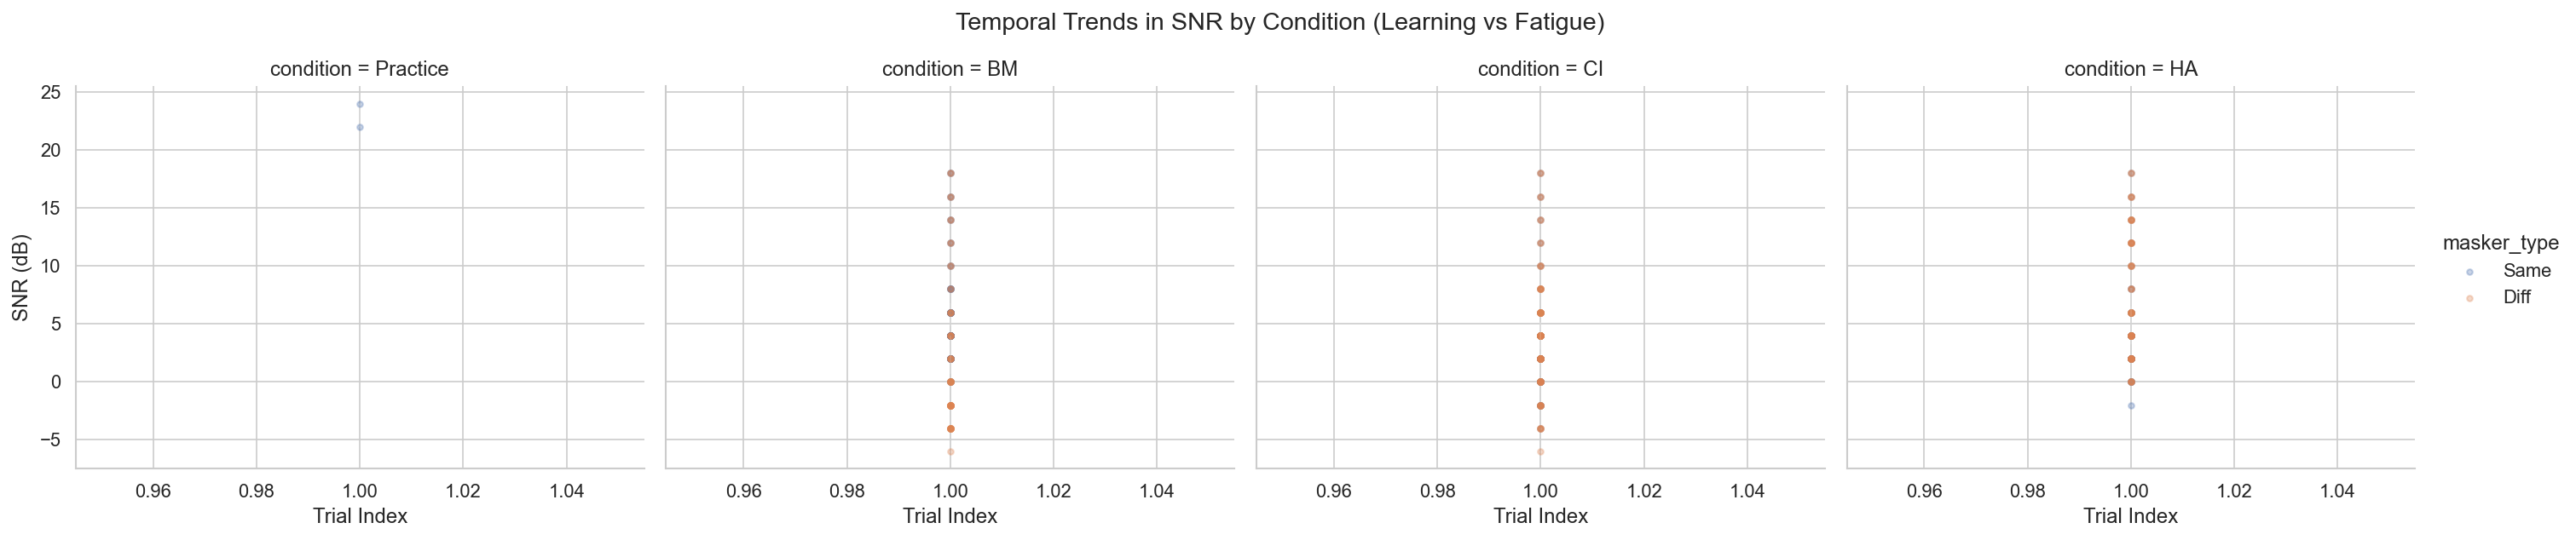

In [7]:
if not df_crm.empty:
    # Create valid subset
    temporal_df = df_crm[df_crm['condition'] != 'Unknown'].copy()
    
    # 6.1 Faceted Temporal Trends
    # We group by Condition to see if fatigue affects specific devices more
    g = sns.lmplot(x="run", y="snr", col="condition", hue="masker_type", 
                   data=temporal_df, scatter_kws={'alpha':0.3, 's':10}, line_kws={'lw':2}, 
                   height=4, aspect=1.2)
    g.fig.suptitle("Temporal Trends in SNR by Condition (Learning vs Fatigue)", y=1.05)
    g.set_axis_labels("Trial Index", "SNR (dB)")
    plt.show()

## 7. Advanced CRM Error Stratification
**Methodology:** Breaks down errors into specific cognitive/perceptual failures:
1.  **Color Error:** Heard the number, missed the color binding.
2.  **Number Error:** Heard the color, missed the number.
3.  **Double Error:** Complete stream segregation failure.

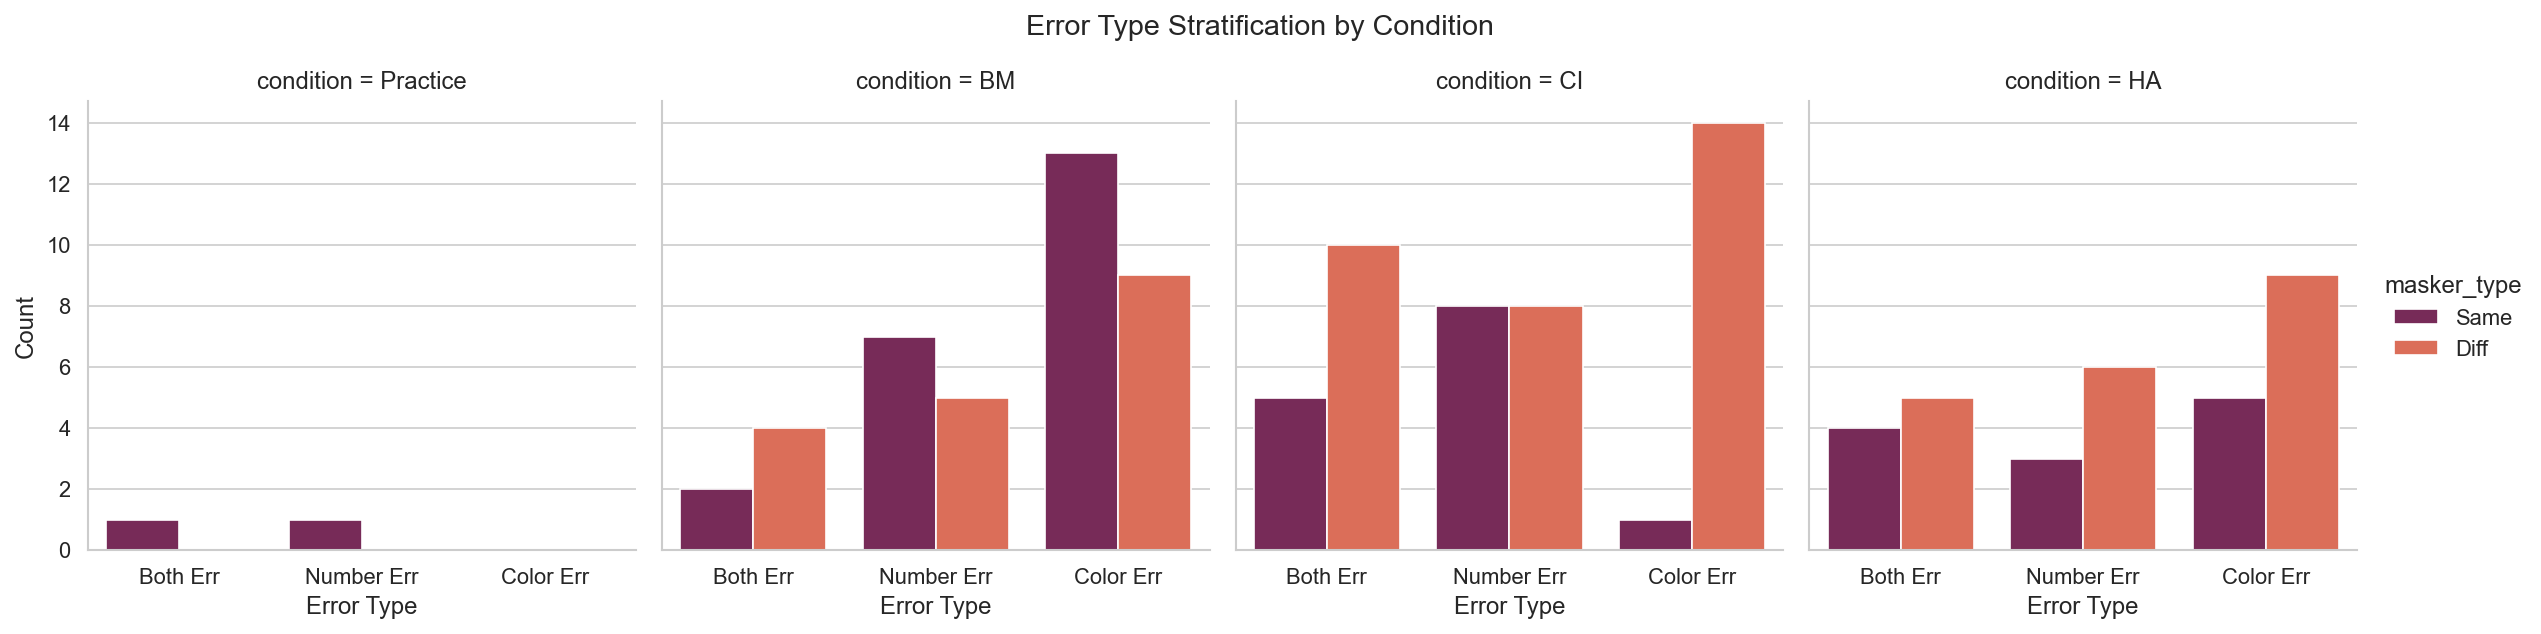

In [8]:
if not df_crm.empty:
    # Filter only errors
    errors_df = df_crm[df_crm['err_type'] != 'Correct']
    
    if not errors_df.empty:
        # 7.1 Small Multiples of Error Types
        g = sns.catplot(
            data=errors_df, kind="count",
            x="err_type", col="condition", hue="masker_type",
            palette="rocket", height=4, aspect=1
        )
        g.fig.suptitle("Error Type Stratification by Condition", y=1.05)
        g.set_axis_labels("Error Type", "Count")
        plt.show()
        
    else:
        print("Subject had 100% accuracy (No errors to analyze).")